In [1]:
import os
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.stats import wilcoxon, mannwhitneyu

In [2]:
skill_1= pd.read_csv('./results/hds_nse_skill/skill_scores.csv')

skill_2= pd.read_csv('./results/raven_nse_skill/skill_scores.csv')

models = {
    'skill_1': 'HYPE-HDS',
    'skill_2': 'Raven'
}

gauge_info= pd.read_csv('../SMM_Models/hype/geospatial/misc/hype_naturalized_flows_summary.csv', index_col=0)

output_dir = './results/hype_raven_comp/'

plot_prefix = 'hds_raven'

# Define periods and corresponding masks, Only use 1 period
periods = {
 #   'calibration': 'cal_mask',
    'validation': 'val_mask',
 #   'all': None  # No mask for 'all'
}

In [3]:
# ===============================
# Preprocessing
# ===============================
# Combine with model labels
skill_1['model'] = models['skill_1']
skill_2['model'] = models['skill_2']
skill_scores_long = pd.concat([skill_1, skill_2], ignore_index=True)

# ===============================
# Map gauge IDs
# ===============================
# Create dictionary mapping subbasin_id to Gauge ID
subbasin_to_gauge = gauge_info['Gauge ID'].to_dict()

# Make sure subbasin column is int
skill_scores_long['subbasin'] = skill_scores_long['subbasin'].astype(int)

# Ensure dictionary keys are int
subbasin_to_gauge = {int(k): v for k, v in subbasin_to_gauge.items()}

# Map gauge IDs
skill_scores_long['gauge_id'] = skill_scores_long['subbasin'].map(subbasin_to_gauge)

# ================
# Sort from West to East
# Ensure subbasin_id is the index in gauge_info
gauge_info_sorted = gauge_info.reset_index().sort_values("Longitude")

# Create a dictionary mapping gauge_id to longitude
gauge_order = gauge_info_sorted["Gauge ID"].tolist()

# Make gauge_id categorical in skill_scores_long with the correct order
skill_scores_long['gauge_id'] = pd.Categorical(
    skill_scores_long['gauge_id'],
    categories=gauge_order,
    ordered=True
)

# Optional: sort the DataFrame by gauge_id for plotting
skill_scores_long = skill_scores_long.sort_values(['gauge_id', 'period', 'benchmark']).reset_index(drop=True)



### Stats

In [4]:
alpha = 0.05  # significance threshold

results = []

df_period = skill_scores_long[skill_scores_long['period'] == period].copy()
gauges = df_period['gauge_id'].unique()

for g in gauges:
    df_g = df_period[df_period['gauge_id'] == g]

    # Separate scores by model
    scores_model1 = df_g[df_g['model'] == models['skill_1']]['skill_score'].values
    scores_model2 = df_g[df_g['model'] == models['skill_2']]['skill_score'].values

    # Remove NaNs pairwise for Wilcoxon
    mask_pair = ~np.isnan(scores_model1) & ~np.isnan(scores_model2)
    scores_model1_clean = scores_model1[mask_pair]
    scores_model2_clean = scores_model2[mask_pair]

    # Wilcoxon paired test
    if len(scores_model1_clean) > 1:
        try:
            w_stat, p_w = wilcoxon(scores_model1_clean, scores_model2_clean)
        except ValueError:
            w_stat, p_w = (float('nan'), float('nan'))
    else:
        w_stat, p_w = (float('nan'), float('nan'))

    # Mann-Whitney U test (treat as independent)
    scores_model1_no_nan = scores_model1[~np.isnan(scores_model1)]
    scores_model2_no_nan = scores_model2[~np.isnan(scores_model2)]
    if len(scores_model1_no_nan) > 0 and len(scores_model2_no_nan) > 0:
        u_stat, p_u = mannwhitneyu(scores_model1_no_nan, scores_model2_no_nan, alternative='two-sided')
    else:
        u_stat, p_u = (float('nan'), float('nan'))

    results.append({
        'gauge_id': g,
        'mean_model1': scores_model1_clean.mean() if len(scores_model1_clean) > 0 else float('nan'),
        'mean_model2': scores_model2_clean.mean() if len(scores_model2_clean) > 0 else float('nan'),
        'wilcoxon_stat': w_stat,
        'p_value_wilcoxon': p_w,
        'wilcoxon_significant': p_w < alpha if not np.isnan(p_w) else False,
        'mannwhitney_stat': u_stat,
        'p_value_mannwhitney': p_u,
        'mannwhitney_significant': p_u < alpha if not np.isnan(p_u) else False
    })

paired_test_results = pd.DataFrame(results)

# Sort by gauge order if desired
paired_test_results = paired_test_results.set_index('gauge_id').loc[gauge_order].reset_index()


NameError: name 'period' is not defined

In [ ]:
paired_test_results

### No CDF

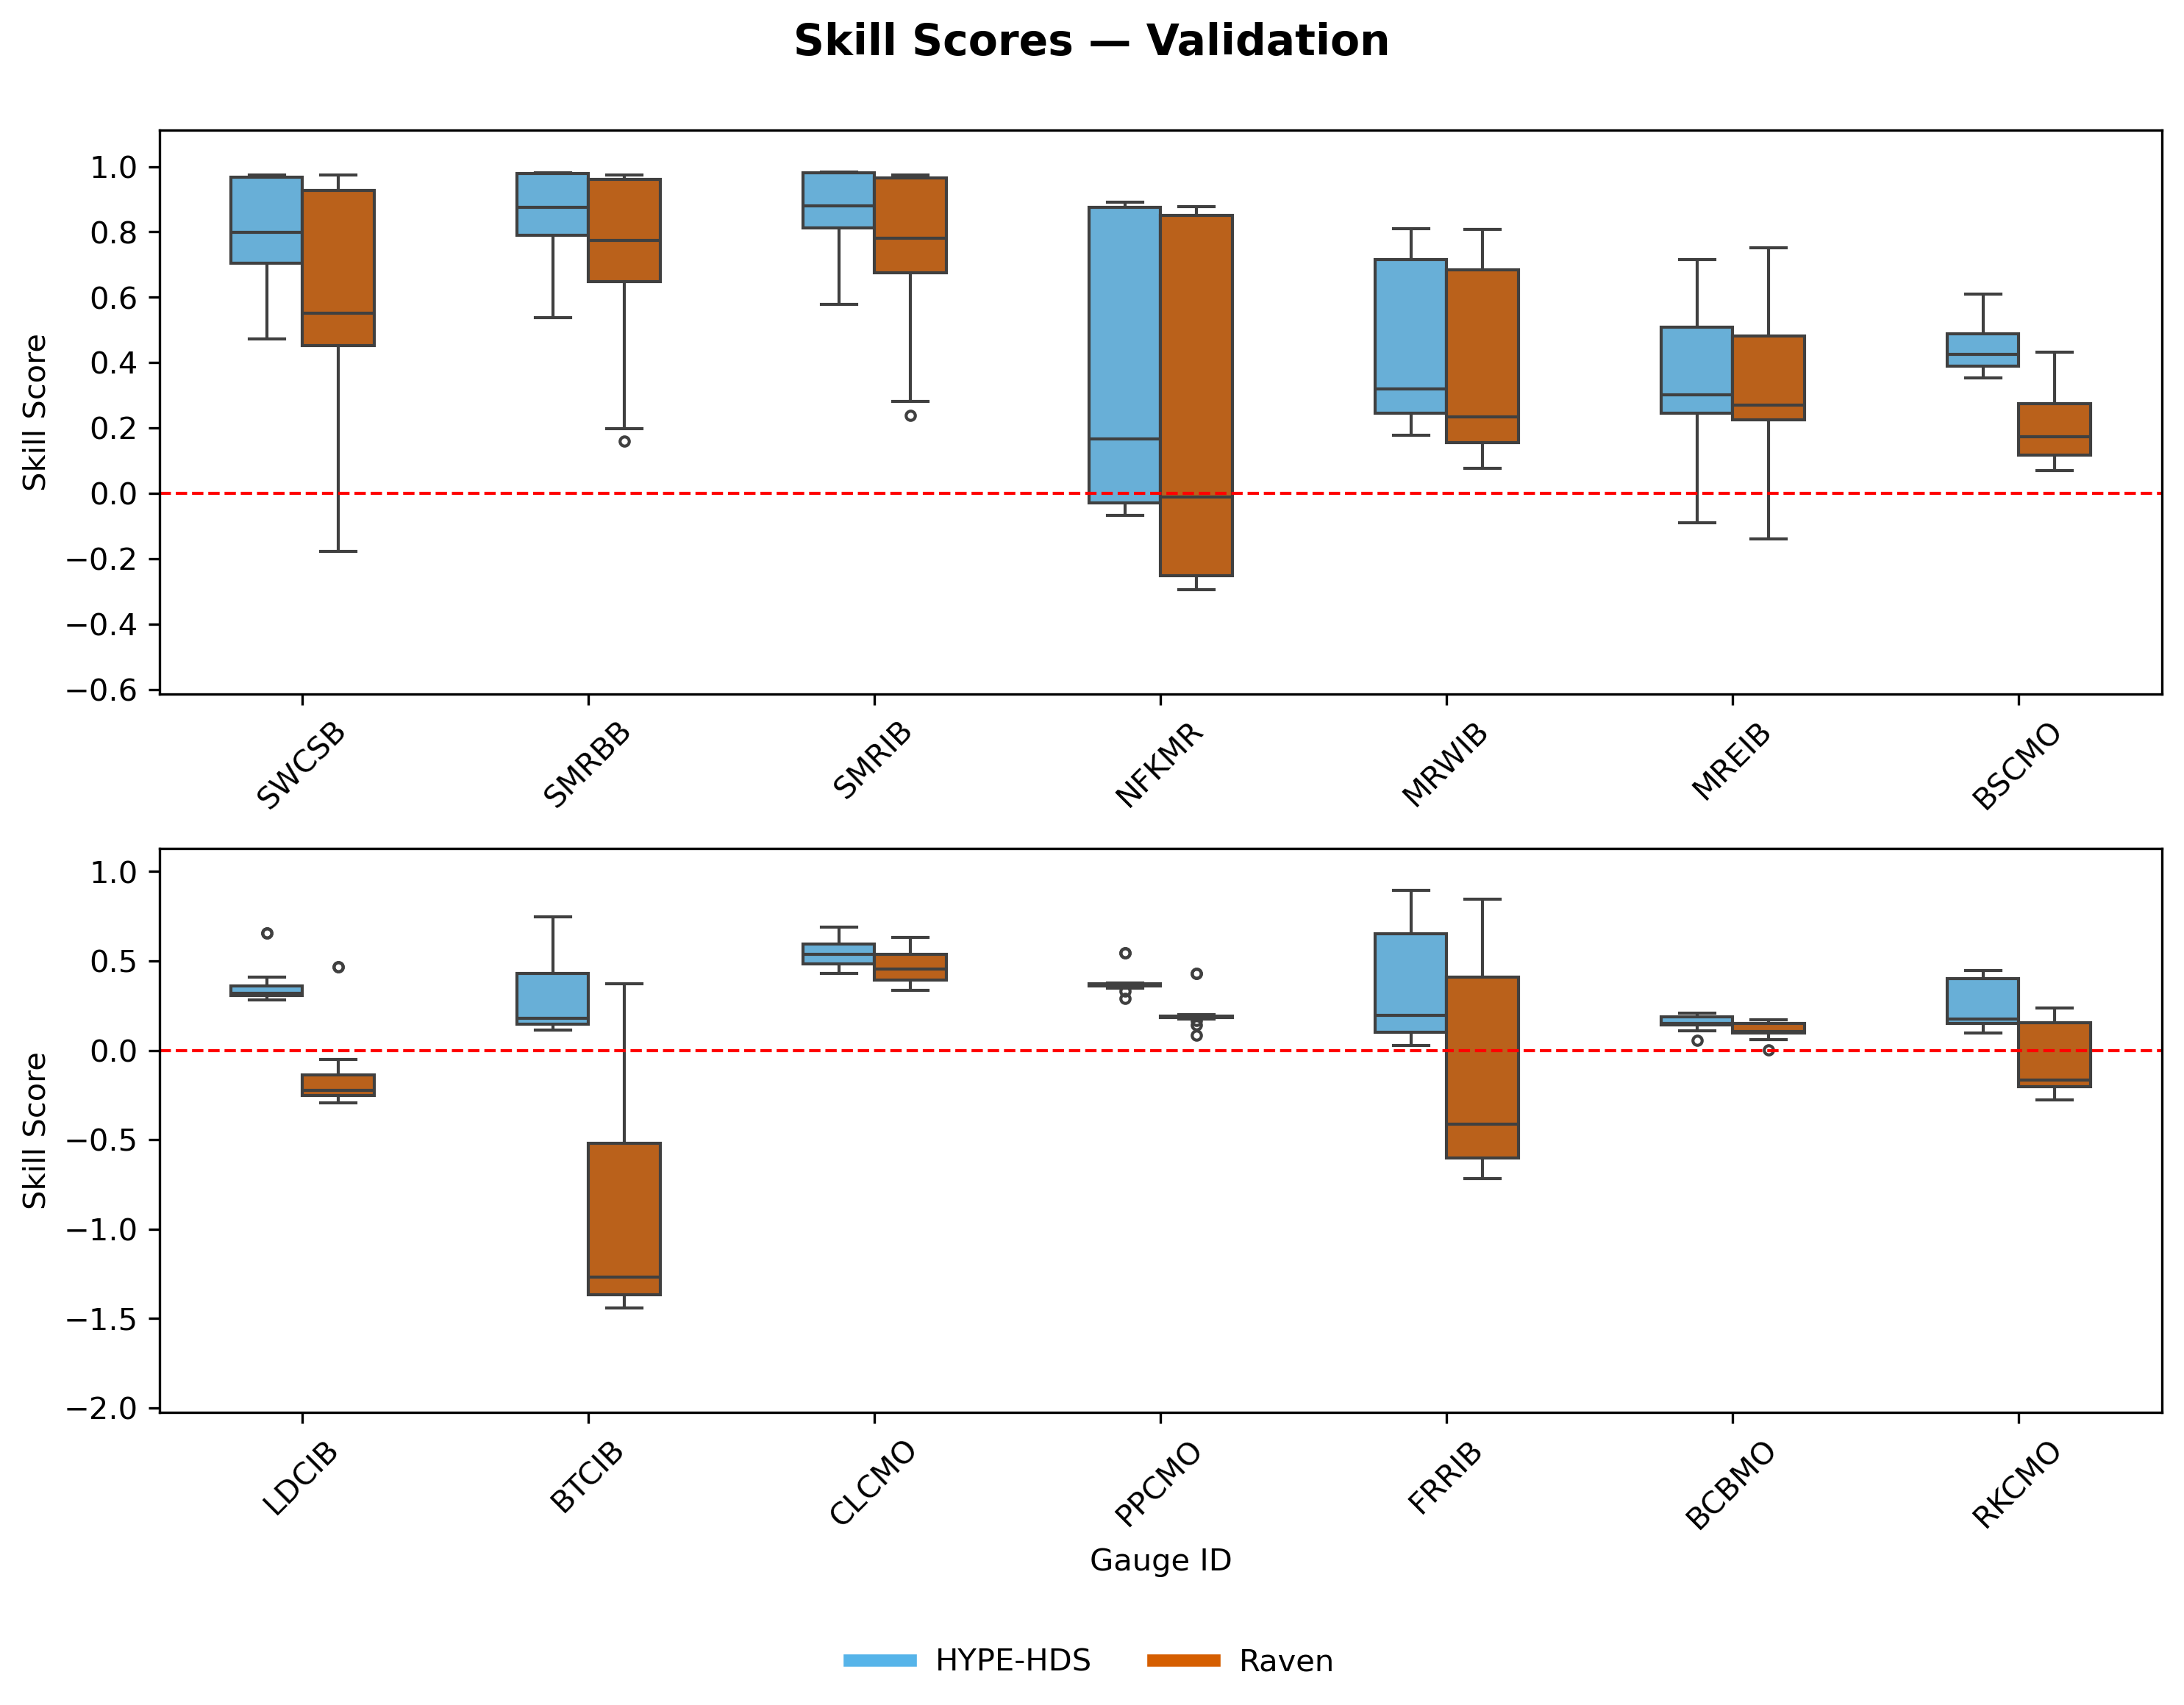

In [5]:
# ===============================
# Colours (CB-friendly)
# ===============================
box_colors = {
    models['skill_1']: "#56B4E9",  # light blue
    models['skill_2']: "#D55E00",  # orange-red
}

alpha = 0.05  # significance threshold

# ===============================
# Plot setup
# ===============================
gauges_per_row = 7  # ✅ Max gauges per subplot
fig_height_per_row = 4

for period in periods:
    df_period = skill_scores_long[skill_scores_long['period'] == period].copy()
    unique_gauges = df_period['gauge_id'].unique()
    n_gauges = len(unique_gauges)

    # Determine number of subplot rows needed
    n_rows = int(np.ceil(n_gauges / gauges_per_row))

    fig, axes = plt.subplots(
        nrows=n_rows, ncols=1,
        figsize=(10, fig_height_per_row * n_rows),
        dpi=300, sharey=False
    )

    if n_rows == 1:
        axes = [axes]

    # Global title
    fig.suptitle(f"Skill Scores — {period.capitalize()}", fontsize=14, weight='bold', y=0.95)

    # ===============================
    # Loop through each subplot row
    # ===============================
    for i, ax in enumerate(axes):
        start_idx = i * gauges_per_row
        end_idx = start_idx + gauges_per_row
        gauges_subset = unique_gauges[start_idx:end_idx]

        df_subset = df_period[df_period['gauge_id'].isin(gauges_subset)].copy()
        df_subset['gauge_id'] = pd.Categorical(
            df_subset['gauge_id'],
            categories=gauges_subset,
            ordered=True
        )

        # -----------------
        # BOX PLOTS
        # -----------------
        sns.boxplot(
            x='gauge_id', y='skill_score', hue='model',
            data=df_subset, ax=ax,
            palette=box_colors, width=0.5, fliersize=3,
            order=gauges_subset,
            dodge=True,
            legend=False
        )

        # -----------------
        # FORMATTING
        # -----------------
        ax.axhline(0, color='red', linestyle='--', linewidth=1)
        ax.set_ylabel("Skill Score", fontsize=10)
        if i == n_rows - 1:
            ax.set_xlabel("Gauge ID", fontsize=10)
        else:
            ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=45)

        # Auto y-limits for this subplot only, with extra space for Wilcoxon text
        y_min = df_subset['skill_score'].min()
        y_max = df_subset['skill_score'].max()
        y_range = y_max - y_min if y_max != y_min else 1.0
        extra_bottom_space = 0.25 * y_range
        ax.set_ylim(y_min - extra_bottom_space, y_max + 0.1*y_range)

        # # Small tick markers & Wilcoxon annotation
        # for x in range(len(gauges_subset)):
        #     ax.vlines(
        #         x, ymin=ax.get_ylim()[0],
        #         ymax=ax.get_ylim()[0] + 0.02*(ax.get_ylim()[1]-ax.get_ylim()[0]),
        #         color='black', linewidth=0.8
        #     )

        #     # Add Wilcoxon result text beneath each box pair
        #     g = gauges_subset[x]
        #     df_g = paired_test_results[paired_test_results['gauge_id'] == g]
        #     if not df_g.empty:
        #         p_val = df_g['p_value_wilcoxon'].values[0]
        #         mean1 = df_g['mean_model1'].values[0]
        #         mean2 = df_g['mean_model2'].values[0]

        #         # Decide text based on significance
        #         if p_val < alpha:
        #             better = models['skill_1'] if mean1 > mean2 else models['skill_2']
        #         else:
        #             better = "No sig. diff"

        #         text = f"{better}\np={p_val:.3g}"

        #         # Place the text relative to bottom of axis
        #         y_bottom = ax.get_ylim()[0]
        #         y_top = ax.get_ylim()[1]
        #         y_text = y_bottom + 0.05*(y_top - y_bottom)

        #         ax.text(
        #             x, y_text,
        #             text, ha='center', va='bottom', fontsize=8
        #         )

    # -----------------
    # Unified global legend
    # -----------------
    from matplotlib.lines import Line2D
    custom_handles = [Line2D([0], [0], color=color, lw=4, label=label)
                      for label, color in box_colors.items()]

    fig.legend(
        handles=custom_handles,
        labels=[h.get_label() for h in custom_handles],
        loc="lower center", ncol=len(models), frameon=False
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    # Save + Show per period
    plt.savefig(
        os.path.join(output_dir, f"{plot_prefix}_skill_scores_boxplot_models_{period}.pdf"),
        dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        os.path.join(output_dir, f"{plot_prefix}_skill_scores_boxplot_models_{period}.png"),
        dpi=300, bbox_inches="tight"
    )
    plt.show()


In [ ]:
threshold = 0.5  # Example threshold

results = []

df_period = skill_scores_long[skill_scores_long['period'] == 'validation'].copy()
gauges = df_period['gauge_id'].unique()

for g in gauges:
    df_g = df_period[df_period['gauge_id'] == g]

    scores_model1 = df_g[df_g['model'] == models['skill_1']]['skill_score'].values
    scores_model2 = df_g[df_g['model'] == models['skill_2']]['skill_score'].values

    # Remove NaNs
    scores_model1 = scores_model1[~np.isnan(scores_model1)]
    scores_model2 = scores_model2[~np.isnan(scores_model2)]

    # Define "good members" as above threshold
    set1 = set(np.where(scores_model1 > threshold)[0])
    set2 = set(np.where(scores_model2 > threshold)[0])

    # Jaccard index
    if len(set1) + len(set2) > 0:
        j_index = len(set1 & set2) / len(set1 | set2)
    else:
        j_index = np.nan

    results.append({
        'gauge_id': g,
        'mean_model1': scores_model1.mean() if len(scores_model1) > 0 else np.nan,
        'mean_model2': scores_model2.mean() if len(scores_model2) > 0 else np.nan,
        'jaccard_index': j_index
    })

jaccard_df = pd.DataFrame(results)


In [ ]:
jaccard_df